In [1]:
%load_ext autoreload
%autoreload 2

# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

# Prepare dataset
We'll be working on our pictures of various UI widgets.

In [2]:
import torch.utils.data as data
from PIL import Image
import os
from datasets import WidgetsDataset

In [3]:
from torchvision import transforms
import torch.nn.functional as F
import torch

def pad_to_size(img: torch.Tensor, size):
    padded = torch.zeros(img.shape[0], size[1], size[0])
    padded[:, :img.shape[1], :img.shape[2]] = img
    return padded

mean, std = 0.1307, 0.3081
train_dataset = WidgetsDataset("/home/adrian/data/Widgets/train",
                               tfm=transforms.Compose([
                                 transforms.Normalize((mean,), (std,)),
                                 lambda x: pad_to_size(x, (1000, 200))
                             ]))
test_dataset = WidgetsDataset('/home/adrian/data/Widgets/dev',
                            tfm=transforms.Compose([
                                transforms.Normalize((mean,), (std,)),
                                lambda x: pad_to_size(x, (1000, 200))
                            ]))
n_classes = 13

## Common setup

In [5]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

widget_classes = ['back_button', 'browser_address', 'browser_bookmark', 'browser_tab', 'button', 'checkbox', 'close_button', 'menu', 'minimize_button', 'next_button', 'slider', 'text_field', 'text_object']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf', '#800080', '#808000', '#F08080']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(13):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(widget_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

# Baseline: Classification with softmax
We'll train the model for classification and use outputs of penultimate layer as embeddings

In [6]:
# Set up data loaders
batch_size = 8
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, ClassificationNet
from metrics import AccumulatedAccuracyMetric

embedding_net = EmbeddingNet()
model = ClassificationNet(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [7]:
fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

/home/adrian/miniconda3/envs/julia/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train: [0/347 (0%)]	Loss: 2.573555	Accuracy: 12.5


Epoch: 1/20. Train set: Average loss: 114.5298	Accuracy: 4.322766570605188
Epoch: 1/20. Validation set: Average loss: 3.2155	Accuracy: 6.25


Train: [0/347 (0%)]	Loss: 2.370544	Accuracy: 0.0


Epoch: 2/20. Train set: Average loss: 5.7737	Accuracy: 6.340057636887608
Epoch: 2/20. Validation set: Average loss: 6.2503	Accuracy: 11.25


Train: [0/347 (0%)]	Loss: 2.702368	Accuracy: 12.5


Epoch: 3/20. Train set: Average loss: 6.6964	Accuracy: 10.951008645533141
Epoch: 3/20. Validation set: Average loss: 11.2165	Accuracy: 6.25


Train: [0/347 (0%)]	Loss: 3.003068	Accuracy: 0.0


Epoch: 4/20. Train set: Average loss: 2.8574	Accuracy: 24.207492795389047
Epoch: 4/20. Validation set: Average loss: 13.8431	Accuracy: 8.75


Train: [0/347 (0%)]	Loss: 46.098763	Accuracy: 37.5


Epoch: 5/20. Train set: Average loss: 55.4075	Accuracy: 14.409221902017292
Epoch: 5/20. Validation set: Average loss: 2.8023	Accuracy: 6.25


Train: [0/347 (0%)]	Loss: 2.615710	Accuracy: 25.0


Epoch: 6/20. Train set: Average loss: 5.4017	Accuracy: 13.832853025936599
Epoch: 6/20. Validation set: Average loss: 3.7402	Accuracy: 15.0


Train: [0/347 (0%)]	Loss: 2.814073	Accuracy: 0.0


Epoch: 7/20. Train set: Average loss: 2.4804	Accuracy: 28.530259365994237
Epoch: 7/20. Validation set: Average loss: 2.5788	Accuracy: 13.75


Train: [0/347 (0%)]	Loss: 2.758895	Accuracy: 12.5


Epoch: 8/20. Train set: Average loss: 2.1300	Accuracy: 32.85302593659942
Epoch: 8/20. Validation set: Average loss: 2.4687	Accuracy: 16.25


Train: [0/347 (0%)]	Loss: 2.052884	Accuracy: 25.0


Epoch: 9/20. Train set: Average loss: 2.1091	Accuracy: 34.293948126801155
Epoch: 9/20. Validation set: Average loss: 2.4121	Accuracy: 21.25


Train: [0/347 (0%)]	Loss: 2.291181	Accuracy: 25.0


Epoch: 10/20. Train set: Average loss: 2.0501	Accuracy: 34.293948126801155
Epoch: 10/20. Validation set: Average loss: 2.4913	Accuracy: 20.0


Train: [0/347 (0%)]	Loss: 2.386687	Accuracy: 37.5


Epoch: 11/20. Train set: Average loss: 2.0311	Accuracy: 34.5821325648415
Epoch: 11/20. Validation set: Average loss: 2.3996	Accuracy: 23.75


Train: [0/347 (0%)]	Loss: 2.097331	Accuracy: 37.5


Epoch: 12/20. Train set: Average loss: 2.0374	Accuracy: 35.15850144092219
Epoch: 12/20. Validation set: Average loss: 2.3751	Accuracy: 21.25


Train: [0/347 (0%)]	Loss: 2.267443	Accuracy: 25.0


Epoch: 13/20. Train set: Average loss: 2.0184	Accuracy: 34.293948126801155
Epoch: 13/20. Validation set: Average loss: 2.3720	Accuracy: 20.0


Train: [0/347 (0%)]	Loss: 2.378355	Accuracy: 12.5


Epoch: 14/20. Train set: Average loss: 2.0019	Accuracy: 35.15850144092219
Epoch: 14/20. Validation set: Average loss: 2.3803	Accuracy: 22.5


Train: [0/347 (0%)]	Loss: 1.941473	Accuracy: 37.5


Epoch: 15/20. Train set: Average loss: 1.9641	Accuracy: 36.023054755043226
Epoch: 15/20. Validation set: Average loss: 2.3360	Accuracy: 20.0


Train: [0/347 (0%)]	Loss: 1.564329	Accuracy: 62.5


Epoch: 16/20. Train set: Average loss: 1.9388	Accuracy: 35.73487031700288
Epoch: 16/20. Validation set: Average loss: 2.3511	Accuracy: 22.5


Train: [0/347 (0%)]	Loss: 2.095546	Accuracy: 37.5


Epoch: 17/20. Train set: Average loss: 1.9144	Accuracy: 36.023054755043226
Epoch: 17/20. Validation set: Average loss: 2.3745	Accuracy: 22.5


Train: [0/347 (0%)]	Loss: 2.055330	Accuracy: 37.5


Epoch: 18/20. Train set: Average loss: 1.9061	Accuracy: 36.023054755043226
Epoch: 18/20. Validation set: Average loss: 2.3777	Accuracy: 22.5


Train: [0/347 (0%)]	Loss: 1.443328	Accuracy: 37.5


Epoch: 19/20. Train set: Average loss: 1.9108	Accuracy: 36.023054755043226
Epoch: 19/20. Validation set: Average loss: 2.3664	Accuracy: 22.5


Train: [0/347 (0%)]	Loss: 1.789573	Accuracy: 37.5


Epoch: 20/20. Train set: Average loss: 1.8999	Accuracy: 36.023054755043226
Epoch: 20/20. Validation set: Average loss: 2.3711	Accuracy: 22.5


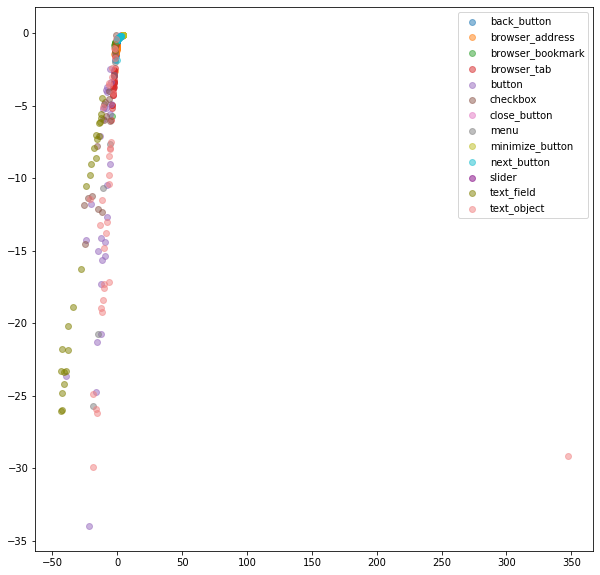

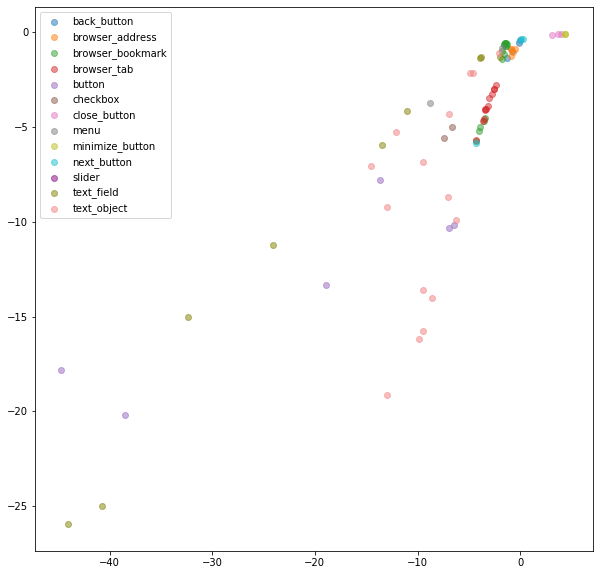

In [8]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

While the embeddings look separable (which is what we trained them for), they don't have good metric properties. They might not be the best choice as a descriptor for new classes.

# Siamese network
Now we'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.
We'll minimize a contrastive loss function*:
$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006*

In [9]:
# Set up data loaders
from datasets import SiameseWidgets

siamese_train_dataset = SiameseWidgets(train_dataset, True) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseWidgets(test_dataset, False)
batch_size = 4
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [10]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/347 (0%)]	Loss: 0.000094


Epoch: 1/20. Train set: Average loss: 15.2025
Epoch: 1/20. Validation set: Average loss: 8.4268


Train: [0/347 (0%)]	Loss: 0.295370


Epoch: 2/20. Train set: Average loss: 7.6351
Epoch: 2/20. Validation set: Average loss: 12.4023


Train: [0/347 (0%)]	Loss: 5.838924


Epoch: 3/20. Train set: Average loss: 13.8677
Epoch: 3/20. Validation set: Average loss: 17.5778


Train: [0/347 (0%)]	Loss: 31.385977


Epoch: 4/20. Train set: Average loss: 6.0027
Epoch: 4/20. Validation set: Average loss: 1.6511


Train: [0/347 (0%)]	Loss: 196.222672


Epoch: 5/20. Train set: Average loss: 19.2731
Epoch: 5/20. Validation set: Average loss: 1.1268


Train: [0/347 (0%)]	Loss: 0.230074


Epoch: 6/20. Train set: Average loss: 0.7837
Epoch: 6/20. Validation set: Average loss: 0.3809


Train: [0/347 (0%)]	Loss: 0.874231


Epoch: 7/20. Train set: Average loss: 0.5937
Epoch: 7/20. Validation set: Average loss: 0.3515


Train: [0/347 (0%)]	Loss: 0.107999


Epoch: 8/20. Train set: Average loss: 0.3372
Epoch: 8/20. Validation set: Average loss: 0.2813


Train: [0/347 (0%)]	Loss: 0.225467


Epoch: 9/20. Train set: Average loss: 0.2028
Epoch: 9/20. Validation set: Average loss: 0.2841


Train: [0/347 (0%)]	Loss: 0.050081


Epoch: 10/20. Train set: Average loss: 0.1698
Epoch: 10/20. Validation set: Average loss: 0.2536


Train: [0/347 (0%)]	Loss: 0.036676


Epoch: 11/20. Train set: Average loss: 0.1678
Epoch: 11/20. Validation set: Average loss: 0.2244


Train: [0/347 (0%)]	Loss: 0.130352


Epoch: 12/20. Train set: Average loss: 0.1236
Epoch: 12/20. Validation set: Average loss: 0.2158


Train: [0/347 (0%)]	Loss: 0.421313


Epoch: 13/20. Train set: Average loss: 0.1271
Epoch: 13/20. Validation set: Average loss: 0.2151


Train: [0/347 (0%)]	Loss: 0.119287


Epoch: 14/20. Train set: Average loss: 0.1339
Epoch: 14/20. Validation set: Average loss: 0.2049


Train: [0/347 (0%)]	Loss: 0.128019


Epoch: 15/20. Train set: Average loss: 0.1211
Epoch: 15/20. Validation set: Average loss: 0.1985


Train: [0/347 (0%)]	Loss: 0.111816


Epoch: 16/20. Train set: Average loss: 0.1293
Epoch: 16/20. Validation set: Average loss: 0.1976


Train: [0/347 (0%)]	Loss: 0.070538


Epoch: 17/20. Train set: Average loss: 0.1417
Epoch: 17/20. Validation set: Average loss: 0.1959


Train: [0/347 (0%)]	Loss: 0.055058


Epoch: 18/20. Train set: Average loss: 0.1424
Epoch: 18/20. Validation set: Average loss: 0.1933


Train: [0/347 (0%)]	Loss: 0.095047


Epoch: 19/20. Train set: Average loss: 0.1262
Epoch: 19/20. Validation set: Average loss: 0.1930


Train: [0/347 (0%)]	Loss: 0.007085


Epoch: 20/20. Train set: Average loss: 0.1251
Epoch: 20/20. Validation set: Average loss: 0.1928


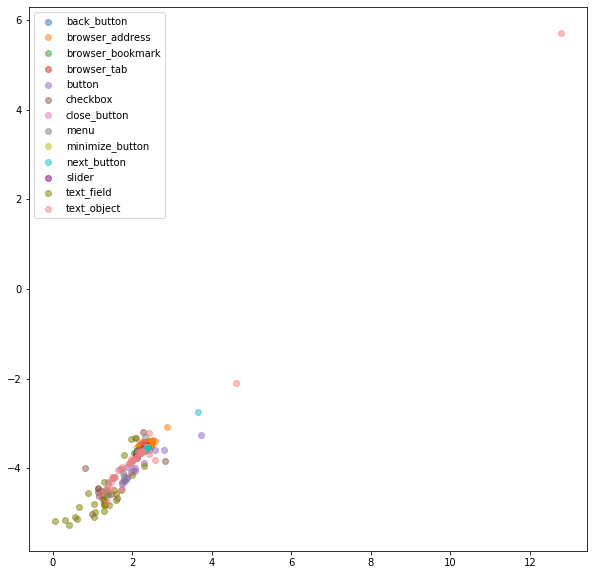

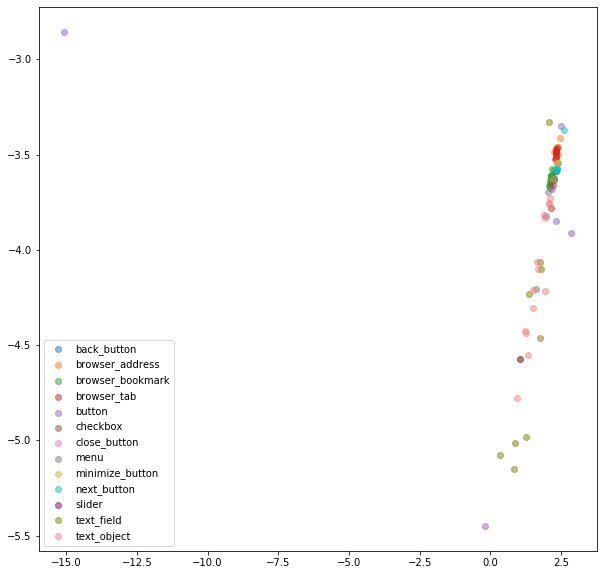

In [11]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

# Set up data loaders
from datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)

# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online pair selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **PairSelector** that takes embeddings and original labels and returns valid pairs within a minibatch
5. Define **OnlineContrastiveLoss** that will use a *PairSelector* and compute *ContrastiveLoss* on such pairs
6. Train the network!

from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

train_embeddings_ocl, train_labels_ocl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_ocl, train_labels_ocl)
val_embeddings_ocl, val_labels_ocl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_ocl, val_labels_ocl)

## Online triplet selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **TripletSelector** that takes embeddings and original labels and returns valid triplets within a minibatch
5. Define **OnlineTripletLoss** that will use a *TripletSelector* and compute *TripletLoss* on such pairs
6. Train the network!

from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)

# display_emb_online, display_emb, display_label_online, display_label = train_embeddings_otl, train_embeddings_tl, train_labels_otl, train_labels_tl
display_emb_online, display_emb, display_label_online, display_label = val_embeddings_otl, val_embeddings_tl, val_labels_otl, val_labels_tl
x_lim = (np.min(display_emb_online[:,0]), np.max(display_emb_online[:,0]))
y_lim = (np.min(display_emb_online[:,1]), np.max(display_emb_online[:,1]))
plot_embeddings(display_emb, display_label, x_lim, y_lim)
plot_embeddings(display_emb_online, display_label_online, x_lim, y_lim)

x_lim = (np.min(train_embeddings_ocl[:,0]), np.max(train_embeddings_ocl[:,0]))
y_lim = (np.min(train_embeddings_ocl[:,1]), np.max(train_embeddings_ocl[:,1]))
plot_embeddings(train_embeddings_cl, train_labels_cl, x_lim, y_lim)
plot_embeddings(train_embeddings_ocl, train_labels_ocl, x_lim, y_lim)